# Homework 1 - Well Testing
## Daniel McAllister-Ou
## DBM2397

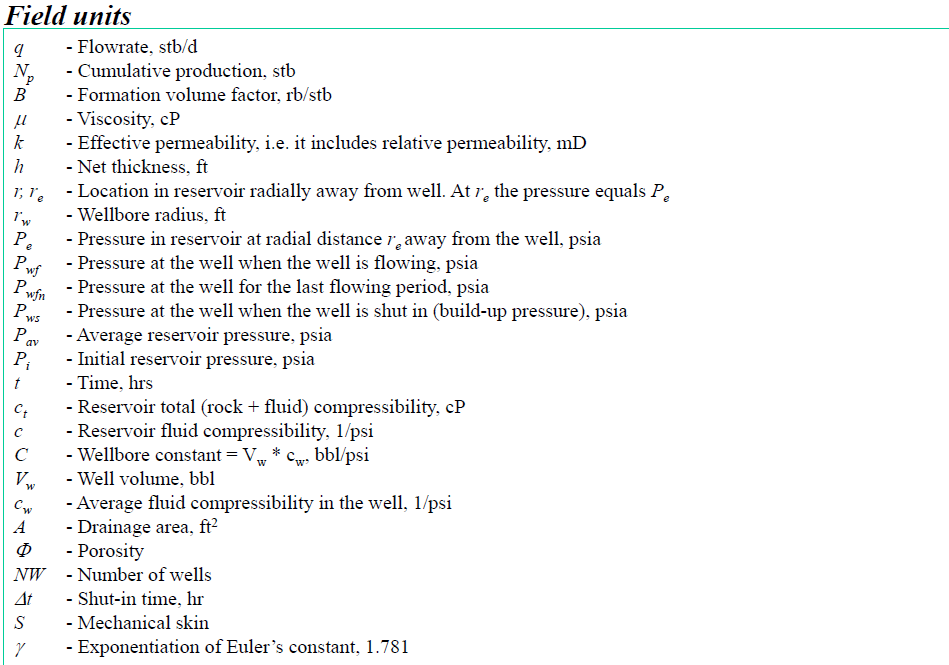

### Q1 
Estimate the duration of the early transient flow period.

t = 121 * phi * mu * ct * A / k 

In [708]:
import numpy as np
import matplotlib.pyplot as plt


Define reservoir properties

In [709]:
def acre_to_ft2(Acre):
    return Acre * 43560  # ft^2

q = 300 #stb/d
Pi = 4000 # psi 
A = acre_to_ft2(80) # acres
rw = 0.25 # ft
h = 50 # ft
phi = 0.2
ct = 15E-6 # psi-1
Bo = 1.2 #rb/stb
mu = 1.5 #cp 
k = 55 # md

In [710]:
def find_early_transient_time(phi,mu,ct,A,k):
    t = 121 * phi * mu * ct * A / k
    # print(f'{121 * phi * mu * ct * A} ')
    return t # hours

early_transient_time = find_early_transient_time(phi,mu,ct,A,k)
print(f"Early Transient Time: {early_transient_time:.2f} hours") 

Early Transient Time: 34.50 hours


### Q2
Calculate the pressure profiles in the reservoir at t = 5 and 20 hrs. and plot on the same graph of
P versus r. Please perform your calculations at the following values of r:

In [711]:
def find_x_for_forlogapprox(phi,mu,ct,rw,k,t):
    return phi * mu * ct * rw**2 / (4*k * t)

def find_re_for_circular_reservoir(A):
    ''' A in ft^2 '''
    re = np.sqrt(A/np.pi)
    return re

n = np.arange(0,9.1,1)
# print(n)
N = np.max(n)

re = find_re_for_circular_reservoir(A) # ft
r = rw * np.exp(n/N * np.log(re/rw)) # ft

x_5hr = find_x_for_forlogapprox(phi,mu,ct,r,k,5)
x_20hr = find_x_for_forlogapprox(phi,mu,ct,r,k,20)
print(f"x_5hr > 0.1: {x_5hr > 0.1}")
print(f"x_20hr > 0.1: {x_20hr > 0.1}")


x_5hr > 0.1: [False False False False False False False False False False]
x_20hr > 0.1: [False False False False False False False False False False]


X << 0.1 therefore log approx. valid 

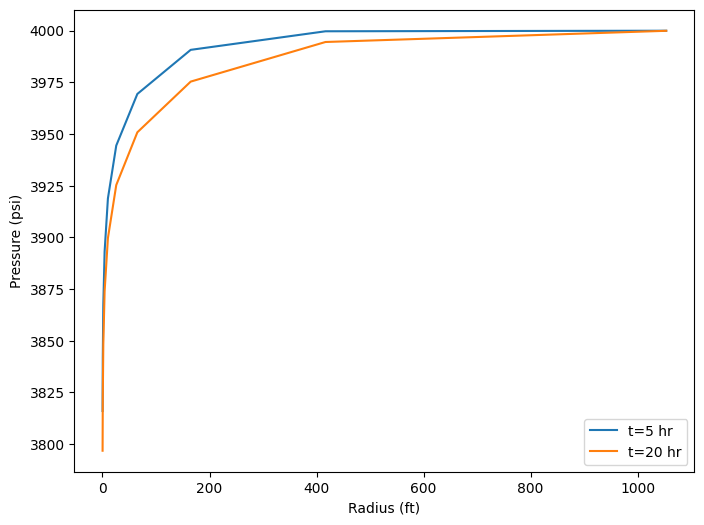

In [712]:
from scipy.special import expi


def Ei_approx(x):
    ''' For small x'''
    return -0.5772 - np.log(x)

def pressure_vs_r_t(Pi,q,mu,Bo,k,h,t,phi,ct,r):
    ''' pressure vs r at time t'''
    # x = find_x_for_forlogapprox(phi,mu,ct,r,k,t)
    # print(f'lnx values for time {t} hr: {np.log(x)}')
    # p = Pi - 141.2*q*mu*Bo/k/h * (-0.5 * Ei_approx(x))
    # print(f'Ei value for time {t} hr: {Ei_approx(x)}')
    
    
    p = Pi - 141.2 * q * mu * Bo / k / h * (-0.5 * expi(-948 * phi * mu * ct * r**2 / k / t))
    return p

p_5hr = pressure_vs_r_t(Pi,q,mu,Bo,k,h,5,phi,ct,r)
p_20hr = pressure_vs_r_t(Pi,q,mu,Bo,k,h,20,phi,ct,r)
# print(f'p_5hr: {p_5hr}')
# print(f'p_20hr: {p_20hr}')
# print(f'r: {r}')
fig,ax = plt.subplots(figsize=(8,6))
ax.plot(r,p_5hr,label='t=5 hr')
ax.plot(r,p_20hr,label='t=20 hr')
ax.set_xlabel('Radius (ft)')
ax.set_ylabel('Pressure (psi)')
plt.legend()

### Q3
Calculate the flowing bottomhole pressures at t(hrs.) = 0.25, 0.5, 0.75, 1,5, 10, 20, 30

In [713]:
def log_approx_inf_res_solution(Pi,q,mu,Bo,k,h,t,phi,ct,rw):
    ''' log approx infinite reservoir solution r = rw'''
    pwf = Pi - (162.6 * q * mu * Bo / k / h) * (np.log10(t) + np.log10(k/phi/mu/ct/rw**2) - 3.23)
    return pwf

def ftsquared_to_acres(ftsquared):
    return ftsquared / 43560.04

def pavg_closed_system(Pi: float, t, q: float, bo: float, A: float, h: float, phi: float, ct: float):
    """Average reservoir pressure vs time for a closed slightly-compressible liquid system."""
    # print(f'debug1 t = {t}')
    t = np.asarray(t, dtype=float)
    # print(f'debug2 t = {t}')
    pore_volume_rb = (A * h * phi) / 5.615
    pavg = Pi - (q * bo) * (t / 24.0) / (pore_volume_rb * ct)
    # print(f'debug3 t = {t}')
    # print(f'pavg for time {t} hr: {pavg}')
    return pavg

    

def pwf_pss(Pi, q, mu, k, h, A, CA, rw, t, phi, ct, S):
    gamma = 0.5772
    term1 = 0.5 * np.log(4*A / (gamma * CA * rw**2))
    term2 = 2 * np.pi * k * t / (phi * mu * ct * A)
    pavg = pavg_closed_system(Pi, t, q, Bo,A, h, phi, ct)
    # print(f"pavg values: {pavg}")
    
    re_ft = find_re_for_circular_reservoir(A)
    dd = 141.2 * (q * Bo * mu) / (k * h) * (np.log(re_ft / rw) - 0.75 + S)
    txtbk = (q * mu / (2 * np.pi * k * h)) * (term1 + term2 + S)
    return pavg - dd

def pwf_piecewise(Pi, q, mu, Bo, k, h, t, phi, ct, rw,
                  time_when_pss_begins, A=None, CA=None, S=None):

    pwf = np.zeros_like(t, dtype=float)

    mask_inf = t < time_when_pss_begins
    mask_pss = t >= time_when_pss_begins

    pwf[mask_inf] = log_approx_inf_res_solution(
        Pi, q, mu, Bo, k, h,
        t[mask_inf],
        phi, ct, rw
    )

    if A is not None and CA is not None and S is not None:
        pwf[mask_pss] = pwf_pss(
            Pi, q, mu, k, h,
            A, CA, rw,
            t[mask_pss],
            phi, ct, S
        )
    else:
        raise ValueError("A, CA, and S must be provided for PSS region.")

    return pwf

pwf_times_030 = [0.25, 0.50, 0.75, 1.00,5.00, 10.0, 20.0, 30.0] # hours
pwf_values_030 = log_approx_inf_res_solution(Pi,q,mu,Bo,k,h,np.array(pwf_times_030),phi,ct,rw)
for t,pwf in zip(pwf_times_030, pwf_values_030):
    x = find_x_for_forlogapprox(phi,mu,ct,rw,k,t)
    print(f"t = {t} hr: pwf = {pwf:.2f} psi, is x small? = {x < 0.1}")


t = 0.25 hr: pwf = 3857.62 psi, is x small? = True
t = 0.5 hr: pwf = 3848.01 psi, is x small? = True
t = 0.75 hr: pwf = 3842.39 psi, is x small? = True
t = 1.0 hr: pwf = 3838.40 psi, is x small? = True
t = 5.0 hr: pwf = 3816.08 psi, is x small? = True
t = 10.0 hr: pwf = 3806.47 psi, is x small? = True
t = 20.0 hr: pwf = 3796.86 psi, is x small? = True
t = 30.0 hr: pwf = 3791.24 psi, is x small? = True


### Q4
Analyze your calculated bottomhole pressures graphically and estimate the formation
permeability and initial reservoir pressure

Slope of pwf vs log time: -31.93
Estimated Permeability: 55.00 md
Estimated Initial Reservoir Pressure: 4000.00 psi


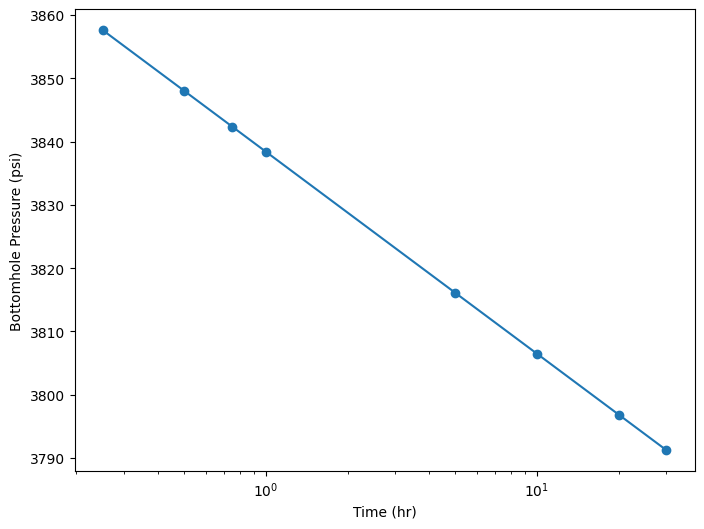

In [714]:
def slope_of_pwft_logt(q,mu,Bo,k,h):
    ''' slope of pwf vs log time '''
    slope = - 162.6 * q * mu * Bo / k / h
    return slope
def find_p_intercept(Pi, slope, k ,phi, mu , ct, rw):
    pintercept = Pi + slope * ( np.log10(k/phi/mu/ct/rw**2) - 3.23)
    return pintercept

def find_formation_permeability(slope,q,mu,bo,h):
    k = -162.6 * q * mu * bo / slope / h
    return k

def find_inital_reservoir_pressure(pintercept, slope, k, phi, mu, ct, rw):
    Pi = pintercept - slope * ( np.log10(k/phi/mu/ct/rw**2) - 3.23)
    return Pi

slope = slope_of_pwft_logt(q,mu,Bo,k,h)
print(f"Slope of pwf vs log time: {slope:.2f}")

pintercept = find_p_intercept(Pi, slope, k ,phi, mu , ct, rw)
estimated_k = find_formation_permeability(slope,q,mu,Bo,h)
estimated_Pi = find_inital_reservoir_pressure(pintercept, slope, estimated_k, phi, mu, ct, rw)

print(f"Estimated Permeability: {estimated_k:.2f} md")
print(f"Estimated Initial Reservoir Pressure: {estimated_Pi:.2f} psi")

fig,ax = plt.subplots(figsize=(8,6))
ax.plot(pwf_times_030, pwf_values_030, marker='o')
ax.set_xscale('log')
ax.set_xlabel('Time (hr)')
ax.set_ylabel('Bottomhole Pressure (psi)')
plt.show()

### Q5
Calculate the time interval for late transient flow.


Assuming that PSS begins when T<sub>DA</sub> = 0.25

In [715]:
def find_time_from_Tda(k,Tda,phi,mu,ct,A):
    t = Tda * (phi * mu * ct * A) / k / 0.0002637
    return t

TDA_pss = 0.25
time_when_pss_begins = find_time_from_Tda(k,TDA_pss,phi,mu,ct,A)
print(f'Time interval for late transient begins at end of early transient: {early_transient_time:.2f} hours')
print(f'Time interval for late transient ends at beginning of pseudosteady state: {time_when_pss_begins:.2f} hours')
print(f'Time interval for late transient flow: hour {early_transient_time:.2f}  - hour {time_when_pss_begins:.2f}')



Time interval for late transient begins at end of early transient: 34.50 hours
Time interval for late transient ends at beginning of pseudosteady state: 270.31 hours
Time interval for late transient flow: hour 34.50  - hour 270.31


### Q6
Calculate the flowing bottomhole pressure at t = 40, 60, 80 and 100 hours.

In [716]:
pwf_times_40100 = [40, 60, 80, 100] # hours
CA = 31.62 # for circular reservoir
pwf_values_40100 = pwf_piecewise(Pi,q,mu,Bo,k,h,np.array(pwf_times_40100),phi,ct,rw,early_transient_time,A=A,CA=CA,S=0)
for t,pwf in zip(pwf_times_40100, pwf_values_40100):
    x = find_x_for_forlogapprox(phi,mu,ct,rw,k,t)
    print(f"t = {t} hr: pwf = {pwf:.2f} psi, is x small? = {x < 0.1}")



t = 40 hr: pwf = 3782.95 psi, is x small? = True
t = 60 hr: pwf = 3779.72 psi, is x small? = True
t = 80 hr: pwf = 3776.50 psi, is x small? = True
t = 100 hr: pwf = 3773.28 psi, is x small? = True


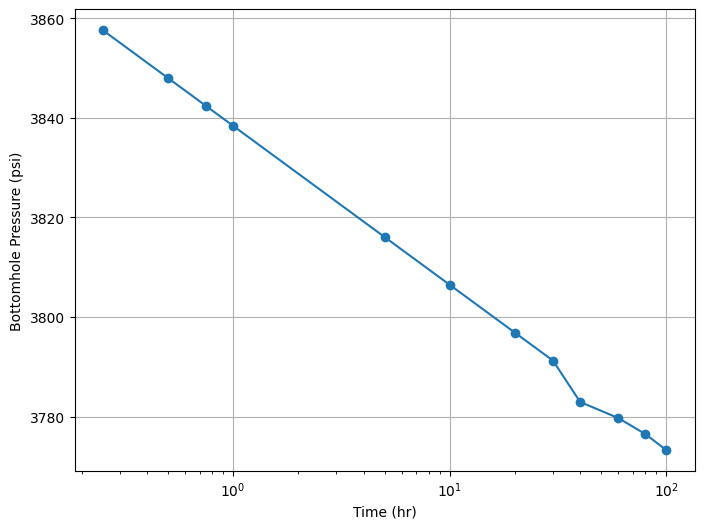

In [717]:
pwf_times = np.concatenate((pwf_times_030, pwf_times_40100))
pwf_values = np.concatenate((pwf_values_030, pwf_values_40100))



fig,ax = plt.subplots(figsize=(8,6))
ax.plot(pwf_times, pwf_values, marker='o')
ax.set_xscale('log')
ax.set_xlabel('Time (hr)')
ax.set_ylabel('Bottomhole Pressure (psi)')
plt.grid('both')
plt.show()

Fit the early straight portion (transient) to find reservoir pressure and K

In [718]:
pwf_times = np.array(pwf_times)
transient_times = pwf_times[pwf_times < early_transient_time]
transient_pwf = pwf_values[pwf_times < early_transient_time]
log_transient_times = np.log10(transient_times)

slope, intercept = np.polyfit(log_transient_times, transient_pwf, 1)

est_k = find_formation_permeability(slope,q,mu,Bo,h)
estimated_Pi = find_inital_reservoir_pressure(intercept, slope, est_k, phi, mu, ct, rw)

print(f"Estimated Permeability from fit: {est_k:.2f} md")
print(f"Estimated Initial Reservoir Pressure from fit: {estimated_Pi:.2f} psi")


Estimated Permeability from fit: 55.00 md
Estimated Initial Reservoir Pressure from fit: 4000.00 psi


Now we find where transient ends and use radius of investigation method 

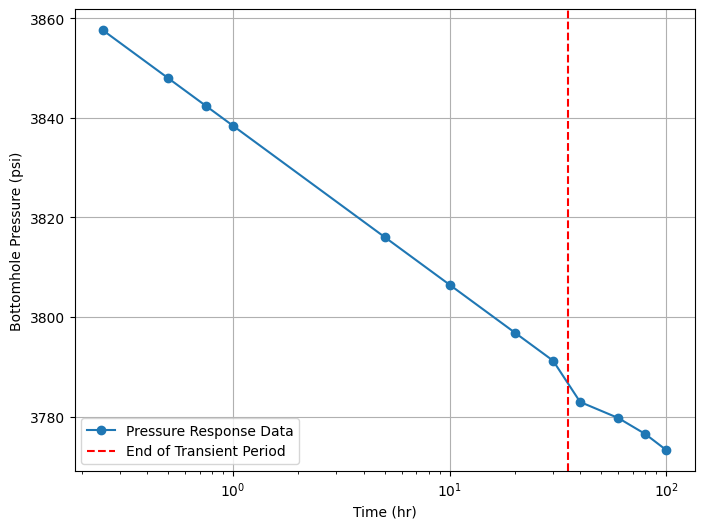

Radius of Investigation at end of Transient Period: 641.21 ft
Estimated Drainage Area: 29.65 acres
Average Reservoir Pressure at end of Test: 3983.89 psi


In [719]:
fig,ax = plt.subplots(figsize=(8,6))
ax.plot(pwf_times, pwf_values, marker='o',label='Pressure Response Data')
ax.axvline(x=35, color='r', linestyle='--', label='End of Transient Period')
ax.set_xscale('log')
ax.set_xlabel('Time (hr)')
ax.set_ylabel('Bottomhole Pressure (psi)')
plt.grid('both')
plt.legend()
plt.show()

avg_resp = pavg_closed_system(Pi,np.max(pwf_times),q,Bo,A,h,phi,ct)

radius_inv = 0.029 * np.sqrt(k * 40 / phi / mu / ct)
print(f'Radius of Investigation at end of Transient Period: {radius_inv:.2f} ft')
est_drainage_area = np.pi * radius_inv**2
print(f'Estimated Drainage Area: {ftsquared_to_acres(est_drainage_area):.2f} acres')
print(f'Average Reservoir Pressure at end of Test: {avg_resp:.2f} psi')

### Q8

Calculate and plot the pressure profiles at t = 300 hours and t = 100 days.

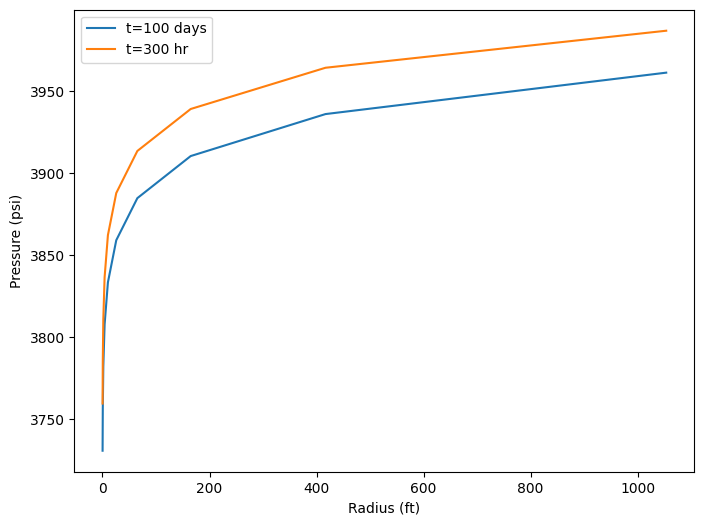

In [720]:
t100day = 100 * 24 # hours

p_100d = pressure_vs_r_t(Pi,q,mu,Bo,k,h,t100day,phi,ct,r)
p_300hr = pressure_vs_r_t(Pi,q,mu,Bo,k,h,300,phi,ct,r)

fig,ax = plt.subplots(figsize=(8,6))
ax.plot(r,p_100d,label='t=100 days')
ax.plot(r,p_300hr,label='t=300 hr')
ax.set_xlabel('Radius (ft)')
ax.set_ylabel('Pressure (psi)')
plt.legend()

### Q9 
Calculate the average reservoir pressure at t = 100 days.

In [721]:
pavg100d = pavg_closed_system(Pi, t100day, q, Bo, A, h, phi, ct)
print(f'Average Reservoir Pressure at t = 100 days: {pavg100d:.2f} psi')


Average Reservoir Pressure at t = 100 days: 3613.29 psi


### Q10
Calculate the pressure drawdown and the ideal productivity index for this well.


In [722]:
pwf100d = pwf_pss(
    Pi, q, mu, k, h,
    A, CA, rw,
    t100day,
    phi, ct, 0
)
drawdown_100d = pavg100d - pwf100d
print(f'Pressure Drawdown at t = 100 days: {drawdown_100d:.2f} psi')
ideal_productivity_index = q / drawdown_100d
print(f'Ideal Productivity Index: {ideal_productivity_index:.2f} stb/day/psi')

Pressure Drawdown at t = 100 days: 210.61 psi
Ideal Productivity Index: 1.42 stb/day/psi


### Q11
Calculate the flowing bottomhole pressures at t=150, 300, 400, 500 and 600 hours.

In [723]:
pwf_times_150600 = [150, 300, 400, 500, 600] # hours
pwf_values_150600 = pwf_piecewise(Pi,q,mu,Bo,k,h,np.array(pwf_times_150600),phi,ct,rw,early_transient_time,A=A,CA=CA,S=0)
for t,pwf in zip(pwf_times_150600, pwf_values_150600):
    print(f"t = {t} hr: pwf = {pwf:.2f} psi")

t = 150 hr: pwf = 3765.22 psi
t = 300 hr: pwf = 3741.05 psi
t = 400 hr: pwf = 3724.94 psi
t = 500 hr: pwf = 3708.83 psi
t = 600 hr: pwf = 3692.72 psi


### Q12
Suppose the calculated bottomhole pressures were actually measured, analyze the pressure data
graphically and estimate the drainage area and the shape factor


Estimated Drainage Area from PSS analysis: 80.00 acres
Estimated Shape Factor from PSS analysis: 31.62


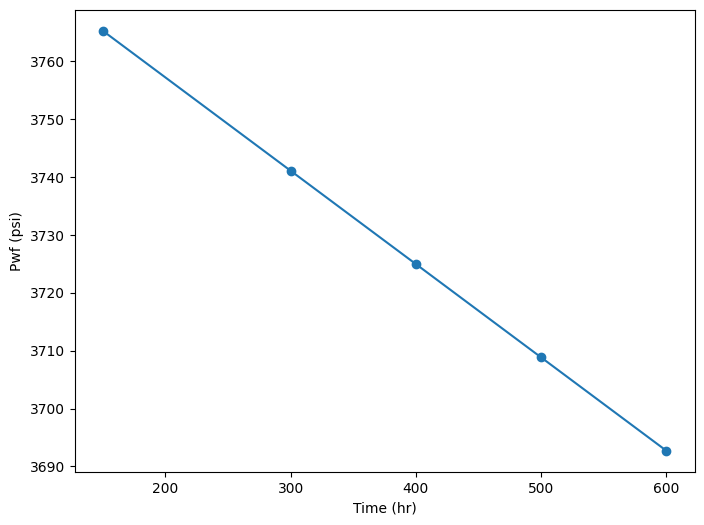

In [724]:
fig,ax = plt.subplots(figsize=(8,6))
ax.plot(pwf_times_150600, pwf_values_150600, marker='o')
ax.set_xlabel('Time (hr)')
ax.set_ylabel('Pwf (psi)')

slope, intercept = np.polyfit(np.array(pwf_times_150600), np.array(pwf_values_150600), 1)
PV_rb = -(q * Bo) / (24.0 * ct * slope)
A_hat_acres = PV_rb * 5.615 / (43560.04 * h * phi)
print(f'Estimated Drainage Area from PSS analysis: {A_hat_acres:.2f} acres')

gamma = 1.781
dp_const_psia = Pi - intercept
F = (k * h / (141.2 * q * Bo * mu)) * dp_const_psia  # dimensionless
A_hat_ft2 = A_hat_acres * 43560.04
C_A_hat = (4.0 * A_hat_ft2) / (gamma * rw**2 * np.exp(2.0 * F))

print(f'Estimated Shape Factor from PSS analysis: {C_A_hat:.2f}')


### Q13
Calculate the flowing bottomhole pressure at t = 100 days given that the drainage shape and well
location are (a) well at the center of a square and (b) well at the center of a quadrant of a 2 x 1
rectangle

In [725]:
C_A_square_center = 30.9
C_A_quadrant_of_2x1_rectangle_center = 2.07

pwf_100d_square = pwf_pss(
    Pi = Pi,
    q = q,
    mu = mu,
    k = k,
    h = h,
    A = A,
    CA = C_A_square_center,
    rw = rw,
    t = t100day,
    phi = phi,
    ct = ct,
    S = 0
)

pwf_100d_quadrant = pwf_pss(
    Pi = Pi,
    q = q,
    mu = mu,
    k = k,
    h = h,
    A = A,
    CA = C_A_quadrant_of_2x1_rectangle_center,
    rw = rw,
    t = early_transient_time,
    phi = phi,
    ct = ct,
    S = 0
)
print(f'Flowing Bottomhole Pressure at t = 100 days (Well at center of square): {pwf_100d_square:.2f} psi')
print(f'Flowing Bottomhole Pressure at t = 100 days (Well at center of quadrant of 2x1 rectangle): {pwf_100d_quadrant:.2f} psi')

Flowing Bottomhole Pressure at t = 100 days (Well at center of square): 3402.68 psi
Flowing Bottomhole Pressure at t = 100 days (Well at center of quadrant of 2x1 rectangle): 3783.83 psi
